In [15]:
from collections import defaultdict as ddict
import dill
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import f1_score
import seaborn as sns

tgt_dataset = 'mscorpus'
src_dataset = 'risec'

## Create the Confusion Matrices

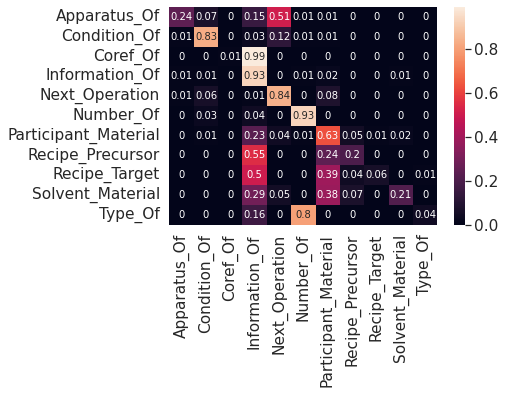

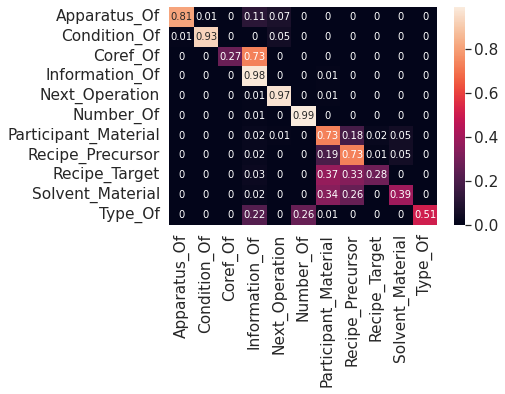

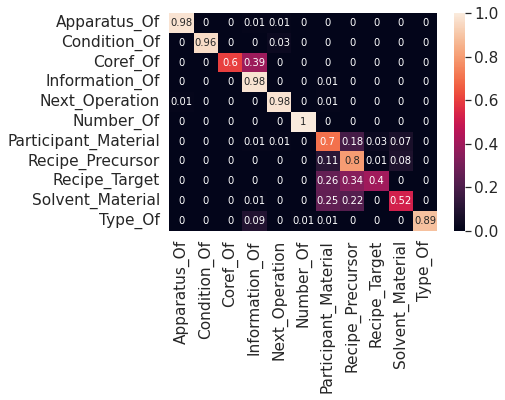

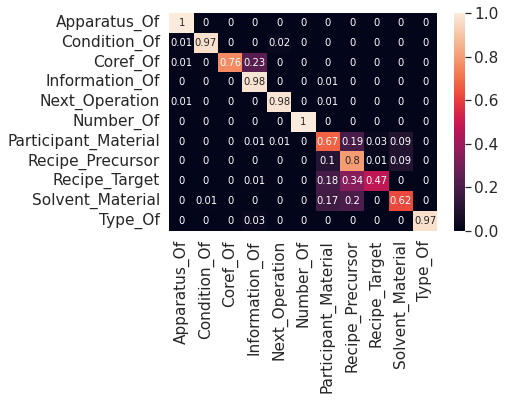

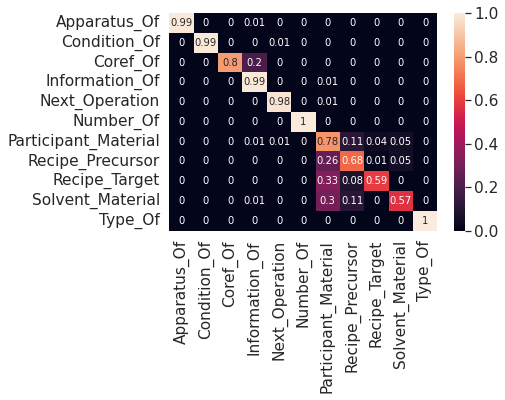

In [3]:
for fewshot in [0.01, 0.05, 0.1, 0.2, 0.5]:
    y_true, y_pred = [], []
    for seed in [0,1,2]:
        csv_file = open(f'/projects/flow_graphs/results/transfer_results_test_{src_dataset}_{tgt_dataset}_{fewshot}_{seed}_amr_residual.csv')
        df       = pd.read_csv(csv_file)
        labels   = sorted(list(set(df['labels'])))
        
        y_true.extend(list(df['labels']))
        y_pred.extend(list(df['predictions']))
        
    conf_matrix = cm(y_true, y_pred)
    df_cm = pd.DataFrame(conf_matrix, index = labels, columns=labels)    
    df_cm = df_cm.div(df_cm.sum(axis=1),axis=0)
    df_cm = df_cm.round(decimals = 2)

    sns.set(font_scale=1.4) # for label size
    sns.heatmap(df_cm, annot=True, annot_kws={"size": 10}) # font size
    plt.savefig(f'../../figures/cm_{src_dataset}_{tgt_dataset}_{fewshot}_amr_residual.png', bbox_inches="tight")
    plt.show()
            
    
        
        

## Observe the distance between entities and its effect on predictions

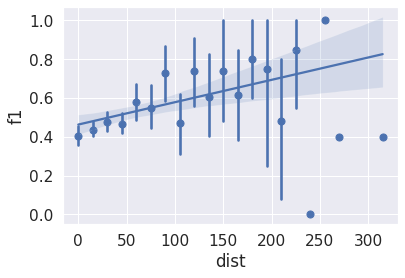

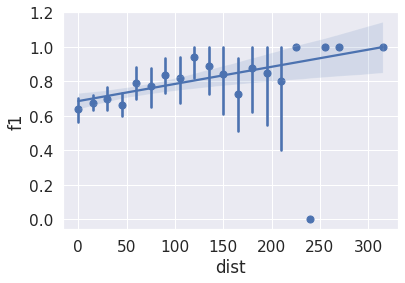

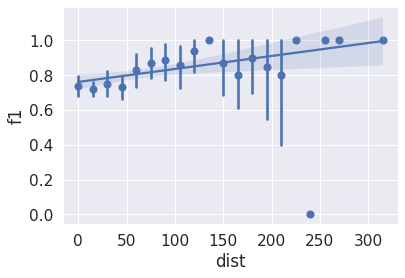

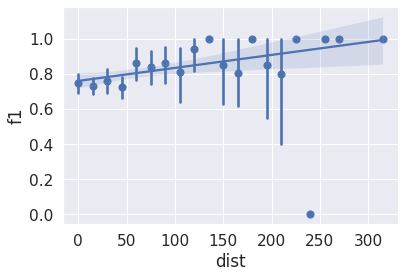

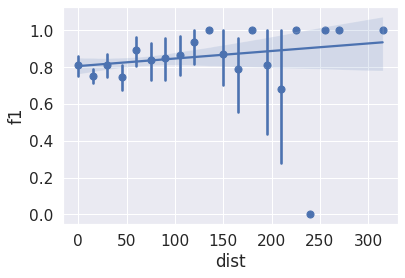

In [4]:
for fewshot in [0.01, 0.05, 0.1, 0.2, 0.5]:
    dist_dict    = ddict(lambda: ddict(list))
    for seed in [0,1,2]:
        csv_file = open(f'/projects/flow_graphs/results/transfer_results_test_{src_dataset}_{tgt_dataset}_{fewshot}_{seed}_amr_residual.csv')
        df       = pd.read_csv(csv_file)
        for index, row in df.iterrows():
            dist = min(abs(row['ent2_end'] - row['ent1_start']), abs(row['ent1_end'] - row['ent2_start']))
            dist_dict[dist]['labels'].append(row['labels'])
            dist_dict[dist]['predictions'].append(row['predictions'])
    
    max_dist        = np.max([dist for dist in dist_dict])
    num_bins        = 20
    width           = int(max_dist/num_bins)
    
    scatter_dist    = ddict(list)
    
    for dist in dist_dict:
        preds       = dist_dict[dist]['predictions']
        labels      = dist_dict[dist]['labels']
        dist2       = int(dist/width)*width
        scatter_dist['dist'].append(dist2)
        scatter_dist['f1'].append(f1_score(labels, preds,average='macro'))
    
    scatter_df    = pd.DataFrame(scatter_dist)
    sns.regplot(data=scatter_df, x= 'dist',y ='f1', x_estimator=np.mean)
    plt.savefig(f'../../figures/char_dist_f1_{src_dataset}_{tgt_dataset}_{fewshot}_amr_residual.png', bbox_inches="tight")
    plt.show()


## Observe the sentence_length and its effect on predictions

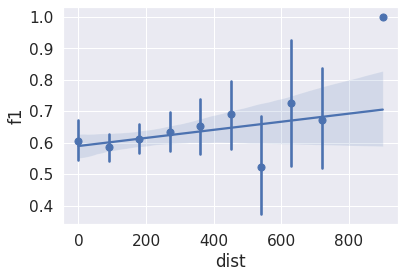

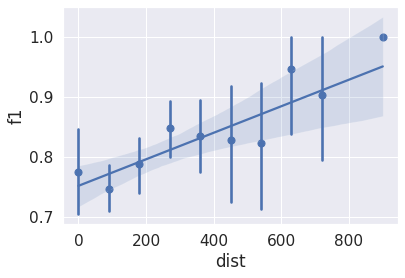

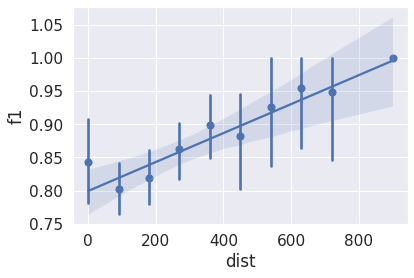

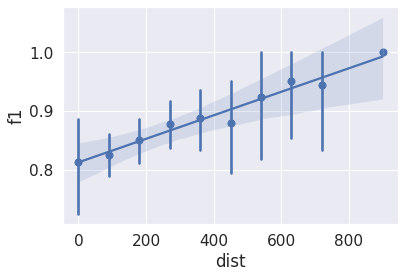

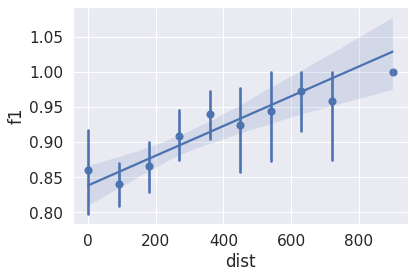

In [5]:
for fewshot in [0.01, 0.05, 0.1, 0.2, 0.5]:
    dist_dict    = ddict(lambda: ddict(list))
    for seed in [0,1,2]:
        csv_file = open(f'/projects/flow_graphs/results/transfer_results_test_{src_dataset}_{tgt_dataset}_{fewshot}_{seed}_amr_residual.csv')
        df       = pd.read_csv(csv_file)
        for index, row in df.iterrows():
            dist = len(row['sent'])
            dist_dict[dist]['labels'].append(row['labels'])
            dist_dict[dist]['predictions'].append(row['predictions'])
    
    # max_dist      = np.max([dist for dist in dist_dict])
    scatter_dist    = ddict(list)
    max_dist        = np.max([dist for dist in dist_dict])
    num_bins        = 10
    width           = int(max_dist/num_bins)
    
    for dist in dist_dict:
        preds       = dist_dict[dist]['predictions']
        labels      = dist_dict[dist]['labels']
        dist2       = int(dist/width)*width
        scatter_dist['dist'].append(dist2)
        scatter_dist['f1'].append(f1_score(labels, preds,average='macro'))
    
    scatter_df    = pd.DataFrame(scatter_dist)
    sns.regplot(data=scatter_df, x= 'dist',y ='f1',x_estimator=np.mean)
    plt.savefig(f'../../figures/sent_len_f1_{src_dataset}_{tgt_dataset}_{fewshot}_amr_residual.png', bbox_inches="tight")
    plt.show()


## Influence of AMR alignment

0.01



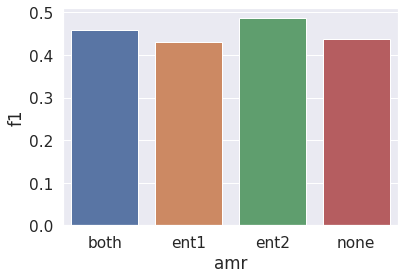

0.05



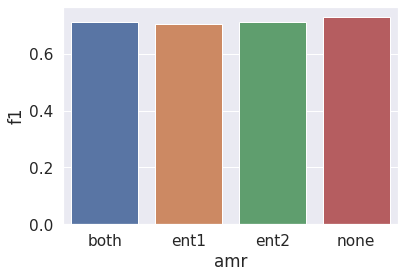

0.1



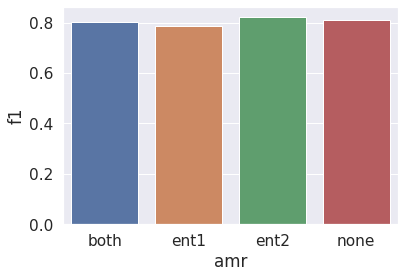

0.2



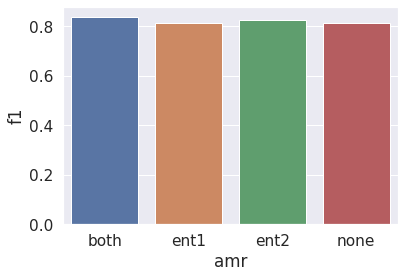

0.5



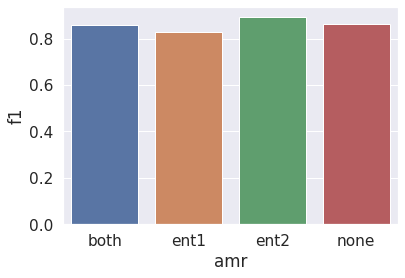

In [16]:
for fewshot in [0.01, 0.05, 0.1, 0.2, 0.5]:
    amr_dict     = ddict(lambda: ddict(list))
    for seed in [0,1,2]:
        csv_file = open(f'/projects/flow_graphs/results/transfer_results_test_{src_dataset}_{tgt_dataset}_{fewshot}_{seed}_amr_residual.csv')
        df       = pd.read_csv(csv_file)
        for index, row in df.iterrows():
            if row['ent1_amr'] > 0 and row['ent2_amr']> 0:
                amrs ='both'
            elif row['ent1_amr'] >0 and row['ent2_amr'] == 0:
                amrs = 'ent1'
            elif row['ent1_amr'] ==0 and row['ent2_amr'] > 0:
                amrs = 'ent2'
            else:
                amrs = 'none'
            amr_dict[amrs]['labels'].append(row['labels'])
            amr_dict[amrs]['predictions'].append(row['predictions'])
    
    bar_dict    = ddict(list)
    for amr in amr_dict:
        preds       = amr_dict[amr]['predictions']
        labels      = amr_dict[amr]['labels']
        bar_dict['amr'].append(amr)
        bar_dict['f1'].append(f1_score(labels, preds, average='macro'))
        bar_dict['count'].append(len(labels))
        
    bar_df      = pd.DataFrame(bar_dict)
    print(fewshot)
    print()
    sns.barplot(data=bar_df, x= 'amr',y ='f1', order = ['both','ent1','ent2','none'])
    plt.show()
    


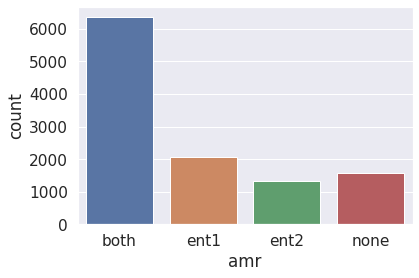

In [17]:
bar_df      = pd.DataFrame(bar_dict)
sns.barplot(data=bar_df, x= 'amr',y ='count', order = ['both','ent1','ent2','none'])
plt.show()


In [14]:
# Is Derivation morphology is the main problem of the AMR parsing and alignment? 

# Can we do pair-wise classification amongst the most confusable pairs? 
# Train pair-wise classifiers for different fewshot pairs. 